In [66]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [67]:
def load_file(path):
    np.random.seed(10)
    data = loadmat(path)
    X = data['ovarianInputs'].T
    Y = data['ovarianTargets'].T
    print(data.keys())
    indices = np.random.permutation(len(Y))
    X = X[indices]
    Y = Y[indices]
    X_train, X_test, X_val = np.split(X, [int(len(X)*0.7), int(len(X)*0.85)])
    Y_train, Y_test, Y_val = np.split(Y, [int(len(Y)*0.7), int(len(Y)*0.85)])
    #normalize data
    X_train = (X_train - np.mean(X_train, axis=0))/np.std(X_train, axis=0)
    X_test = (X_test - np.mean(X_test, axis=0))/np.std(X_test, axis=0)
    X_val = (X_val - np.mean(X_val, axis=0))/np.std(X_val, axis=0)
    print(X_train.T.shape, X_test.T.shape, X_val.T.shape, Y_train.T.shape, Y_test.T.shape, Y_val.T.shape)
    print("Training data size: ",X_train.T.shape)
    print("Training label size: ",Y_train.T.shape)
    print("Testing data size: ",X_test.T.shape)
    print("Testing label size: ",Y_test.T.shape)
    print("Validation data size: ",X_val.T.shape)
    print("Validation label size: ",Y_val.T.shape)
    return X_train.T, X_test.T,Y_train.T,Y_test.T,X_val.T,Y_val.T

dataset = load_file('C:/Users/Prajyot/Downloads/ovarian_dataset.mat')

dict_keys(['__header__', '__version__', '__globals__', 'ovarianInputs', 'ovarianTargets'])
(100, 151) (100, 32) (100, 33) (2, 151) (2, 32) (2, 33)
Training data size:  (100, 151)
Training label size:  (2, 151)
Testing data size:  (100, 32)
Testing label size:  (2, 32)
Validation data size:  (100, 33)
Validation label size:  (2, 33)


In [68]:
m = 1
def initialize(n_x,C1,C2):
#     global W,b
    np.random.seed(10)
    W1 = np.random.randn(n_x,C1)*0.1
    b1 = np.zeros((C1,1))
    W2 = np.random.randn(C1,C2)*0.1
    b2 = np.zeros((C2,1))

    return W1, b1, W2, b2

def softmax(z):
    t = np.exp(z)
    a = t / np.sum(t, keepdims=True, axis=0)
    return a

def sigmoid(z):
    return 1/(1+np.exp(-z))

def forward(W, X, b,activation=None):
#     global Z,A
    Z = np.dot(W.T, X) + b # Z.shape is (C,m)
    if activation == 'sigmoid':
        A = sigmoid(Z)
    else:
        A = Z
    return Z, A
def cost(A, Y_hot):
#     global L,J
# Calculate Loss
    L = 0.5*np.sum((A-Y_hot),keepdims=True, axis=0) # L.shape is (C,m)
    J = np.mean(L)
    return L,J

# Genralized backprop function for multiple layers
def backward(X, Y_hot, A, Z, W, b, activation=None,cache=None):
#     global dW,db
    if activation == 'softmax':
        dZ = A - Y_hot
    elif activation == 'sigmoid':
        dZ = np.dot(cache[1],cache[0])*A*(1-A)
    else:
        dZ = A - Y_hot

    dW = np.dot(X, dZ.T)/m
    db = np.mean(dZ, keepdims=True, axis=1)
    return dW, db,dZ

def update(W, b, dW, db, learning_rate):
    W = W - learning_rate*dW
    b = b - learning_rate*db
    return W,b

def SGD(X, Y_hot, W1, b1, W2, b2, learning_rate):
    Z1, A1 = forward(W1, X, b1, 'sigmoid')
    Z2, A2 = forward(W2, A1, b2, 'softmax')
    L, J = cost(A2, Y_hot)
    dW2, db2,dZ2 = backward(A1, Y_hot, A2, Z2, W2, b2)
    dW1, db1,_ = backward(X, Y_hot, A1, Z1, W1, b1, 'sigmoid',cache=(dZ2,W2))
    W1,b1 = update(W1, b1, dW1, db1, learning_rate)
    W2,b2 = update(W2, b2, dW2, db2, learning_rate)
    return W1,b1,W2,b2,J


def predict(W1, b1, W2, b2, X):
    _, A1 = forward(W1, X, b1, 'sigmoid')
    _, A2 = forward(W2, A1, b2, 'softmax')
    return A2

def accuracy(Y_pred, Y):
    return np.mean(Y_pred == Y)

W1, b1, W2, b2 = initialize(100, 15, 2)
learning_rate = 0.001
costs = []
accs = []
#use SGD to train the model and validate at same time
for i in range(100):
    for j in range(dataset[0].shape[1]):
        X = dataset[0][:,j].reshape(-1,1)
        Y = dataset[2][:,j].reshape(-1,1)
        W1,b1,W2,b2,J = SGD(X, Y, W1, b1, W2, b2, learning_rate)
    costs.append(abs(J))
    #validate
    Y_pred = predict(W1, b1, W2, b2, dataset[4])
    acc = accuracy(np.argmax(Y_pred, axis=0), np.argmax(dataset[5], axis=0))
    print(f'Epoch {i+1}: Cost {J}, Val_accuracy {acc}')
    accs.append(acc)

# plt.plot(costs)
# plt.show()
# plt.plot(accs)
# plt.show()

Y_pred = predict(W1, b1, W2, b2, dataset[1])

# confusion matrix
from sklearn.metrics import confusion_matrix
Y_final = np.where(Y_pred >= 0.6, 1, 0)
accuracy(Y_final,dataset[3])
# print("Accuracy: ", accuracy(Y_final,dataset[3])*100,"%")
cfm = confusion_matrix(np.argmax(dataset[3],axis=0), np.argmax(Y_pred, axis=0))
TP = cfm[0][0]
TN = cfm[1][1]
FP = cfm[1][0]
FN = cfm[1][0]
#Specificity
Specificity = TN/(TN+FP)
#Sensitivity
Sensitivity = TP/(TP+FN)
# print(f'Specificity: {Specificity}, Sensitivity: {Sensitivity}')

Epoch 1: Cost -0.1281306033411062, Val_accuracy 0.5454545454545454
Epoch 2: Cost -0.05264228550853542, Val_accuracy 0.6666666666666666
Epoch 3: Cost -0.016604383854513155, Val_accuracy 0.7878787878787878
Epoch 4: Cost 0.00028422346262602094, Val_accuracy 0.8181818181818182
Epoch 5: Cost 0.007980468142481462, Val_accuracy 0.8181818181818182
Epoch 6: Cost 0.01132770799487437, Val_accuracy 0.8181818181818182
Epoch 7: Cost 0.012665107466805853, Val_accuracy 0.8181818181818182
Epoch 8: Cost 0.01311118387238075, Val_accuracy 0.8181818181818182
Epoch 9: Cost 0.013191827806549622, Val_accuracy 0.7878787878787878
Epoch 10: Cost 0.01314693785012952, Val_accuracy 0.7878787878787878
Epoch 11: Cost 0.013079880387603604, Val_accuracy 0.7878787878787878
Epoch 12: Cost 0.013030117510442099, Val_accuracy 0.8181818181818182
Epoch 13: Cost 0.013008284905737494, Val_accuracy 0.8181818181818182
Epoch 14: Cost 0.013012935424762825, Val_accuracy 0.8181818181818182
Epoch 15: Cost 0.013038354935778124, Val_acc

In [69]:
print("Accuracy: ", accuracy(Y_final,dataset[3])*100,"%")
print(f'Specificity: {Specificity}, Sensitivity: {Sensitivity}')

Accuracy:  92.1875 %
Specificity: 0.9333333333333333, Sensitivity: 0.9411764705882353


Text(0.5, 1.0, 'Validation Accuracy vs Epoch')

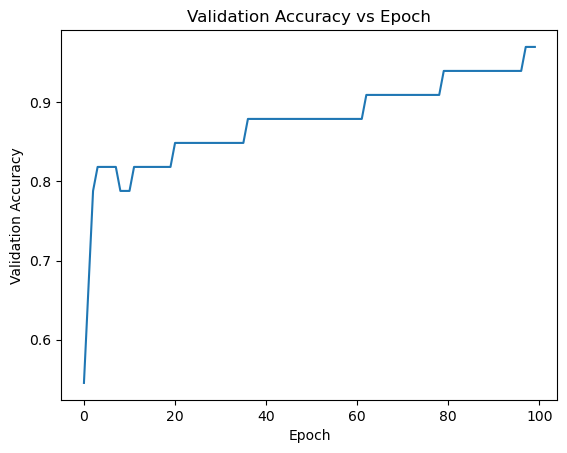

In [70]:
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Epoch')

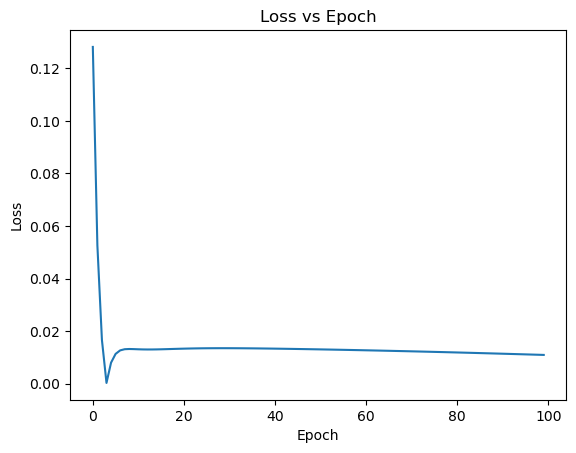

In [71]:
plt.plot(costs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

Text(0.5, 1.0, 'ROC Curve')

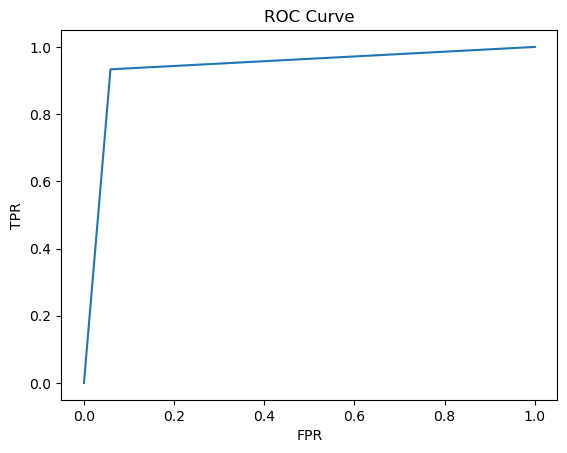

In [72]:
# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(np.argmax(dataset[3],axis=0), np.argmax(Y_pred, axis=0))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

In [73]:
#AUC
from sklearn.metrics import auc
print("Accuracy: ", accuracy(Y_final,dataset[3])*100,"%")
print(f'Specificity: {Specificity}, Sensitivity: {Sensitivity}')
print("AUC = ",auc(fpr, tpr))

Accuracy:  92.1875 %
Specificity: 0.9333333333333333, Sensitivity: 0.9411764705882353
AUC =  0.9372549019607843
